<a href="https://colab.research.google.com/github/GianvitoC/Causal_Fairness/blob/main/CausalDiscoveryRecSys.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install DoWhy package

In [1]:
!pip install dowhy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 164 kB 11.6 MB/s 
  Attempting uninstall: pydot
    Found existing installation: pydot 1.3.0
    Uninstalling pydot-1.3.0:
      Successfully uninstalled pydot-1.3.0


In [2]:
import dowhy
dowhy.__version__

'0.7.1'

Install LiNGAM package

In [3]:
!pip install lingam

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 67 kB 3.3 MB/s 


In [4]:
import lingam
lingam.__version__

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


'1.5.5'

Install Scikit 

In [5]:
!pip install scikit-learn==1.0.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
import sklearn

sklearn.__version__

'1.0.2'

Import needed packages.
Initialize seed

In [11]:
from dowhy import CausalModel
import lingam
from lingam.utils import make_dot, make_prior_knowledge
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
import graphviz
np.set_printoptions(precision=3, suppress=True)
np.random.seed(0)

Define helper function to convert input string from graphviz library to valid DOT graph format.

In [30]:
def str_to_dot(string):
    '''
    Converts input string from graphviz library to valid DOT graph format.
    '''
    graph = string.replace('\n', ';').replace('\t','')
    #graph = graph[:9] + graph[161:-16] + graph[-1] # Removing unnecessary characters from string / Case w/ Gini Items
    graph = graph[:9] + graph[135:-16] + graph[-1] # Removing unnecessary characters from string / Case w/o Gini Items
    return graph

Define helper functions

In [37]:
def my_plot_causal_effect(estimate, treatment_lab, outcome_lab, treatment, outcome):
    fig, ax = plt.subplots()
    ax.scatter(treatment, outcome, c="gray", marker="o", label="Observed data")
    y_min = -1
    y_max = 1
    x_min = (y_min - estimate.params["intercept"])/estimate.value
    x_max = (y_max - estimate.params["intercept"])/estimate.value
    ax.plot([x_min, x_max], [y_min, y_max], c="black", ls="solid", lw=4,
            label="Causal variation")
    bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.9)
    ax.text(1.0, 1.2, r"Estimate (slope) = " + str(round(estimate.value, 2)),
            ha="right", va="bottom", size=20, bbox=bbox_props)
    ax.legend(loc="upper left")
    plt.xlabel(treatment_lab,fontsize=20)
    plt.ylabel(outcome_lab,fontsize=20)
    plt.rcParams['font.size'] = 25
    fig.set_size_inches(8, 6)
    fig.savefig(
        "/drive/My Drive/Colab Notebooks/causal_plot" + datetime.now().strftime("%H-%M-%S") + ".png",
                bbox_inches='tight')
def my_plot_causal_effect_inv(estimate, treatment_lab, outcome_lab, treatment, outcome):
    fig, ax = plt.subplots()
    ax.scatter(treatment, outcome, c="gray", marker="o", label="Observed data")
    x_min = 1
    x_max = 3.0
    y_min = x_min*estimate.value + estimate.params["intercept"]
    y_max = x_max*estimate.value + estimate.params["intercept"]
    ax.plot([x_min, x_max], [y_min, y_max], c="black", ls="solid", lw=4,
            label="Causal variation")
    bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.9)
    ax.text(1, 33  , r"Estimate (slope) = " + str(round(estimate.value, 2)),
            ha="right", va="bottom", size=20, bbox=bbox_props)
    ax.legend(loc="upper left")
    plt.xlabel(treatment_lab,fontsize=20)
    plt.ylabel(outcome_lab,fontsize=20)
    plt.rcParams['font.size'] = 25
    fig.set_size_inches(8, 6)
    fig.savefig(
        "causal_plot" + datetime.now().strftime("%H-%M-%S") + ".png",
                bbox_inches='tight')
def make_prior_knowledge_graph(prior_knowledge_matrix):
    d = graphviz.Digraph(engine='dot')

    labels = [f'x{i}' for i in range(prior_knowledge_matrix.shape[0])]
    for label in labels:
        d.node(label, label)

    dirs = np.where(prior_knowledge_matrix > 0)
    for to, from_ in zip(dirs[0], dirs[1]):
        d.edge(labels[from_], labels[to])

    dirs = np.where(prior_knowledge_matrix < 0)
    for to, from_ in zip(dirs[0], dirs[1]):
        if to != from_:
            d.edge(labels[from_], labels[to], style='dashed')
    return d

Import Dataset and DataFrame preparation 

In [12]:
from google.colab import drive
drive.mount('/drive')

Mounted at /drive


In [13]:
df = pd.read_csv('/drive/My Drive/Colab Notebooks/datasets_causal_Netflix_norm.csv')
#df = pd.read_csv('datasets_causal_Netflix_norm.csv')
df.dropna(inplace=True)

print(df.head())
print(df.shape)

   Relative log10Sparsity  Relative log10Shape  Relative Gini for users  \
0                1.000000             1.000000                 1.000000   
1                1.092756             1.029526                 0.999656   
2                1.349700             1.215432                 0.946182   
3                1.250599             1.132273                 0.983050   
4                1.268181             1.145834                 0.979200   

   Relative Gini for items  Relative Popularity bias  Kendall tau for NDCG@5  
0                 1.000000                  1.000000                1.000000  
1                 0.995641                  0.973462                0.866667  
2                 0.943779                  0.732860               -0.200000  
3                 0.973720                  0.858901                0.733333  
4                 0.969322                  0.837590               -0.200000  
(41, 6)


Exploring Dataset 

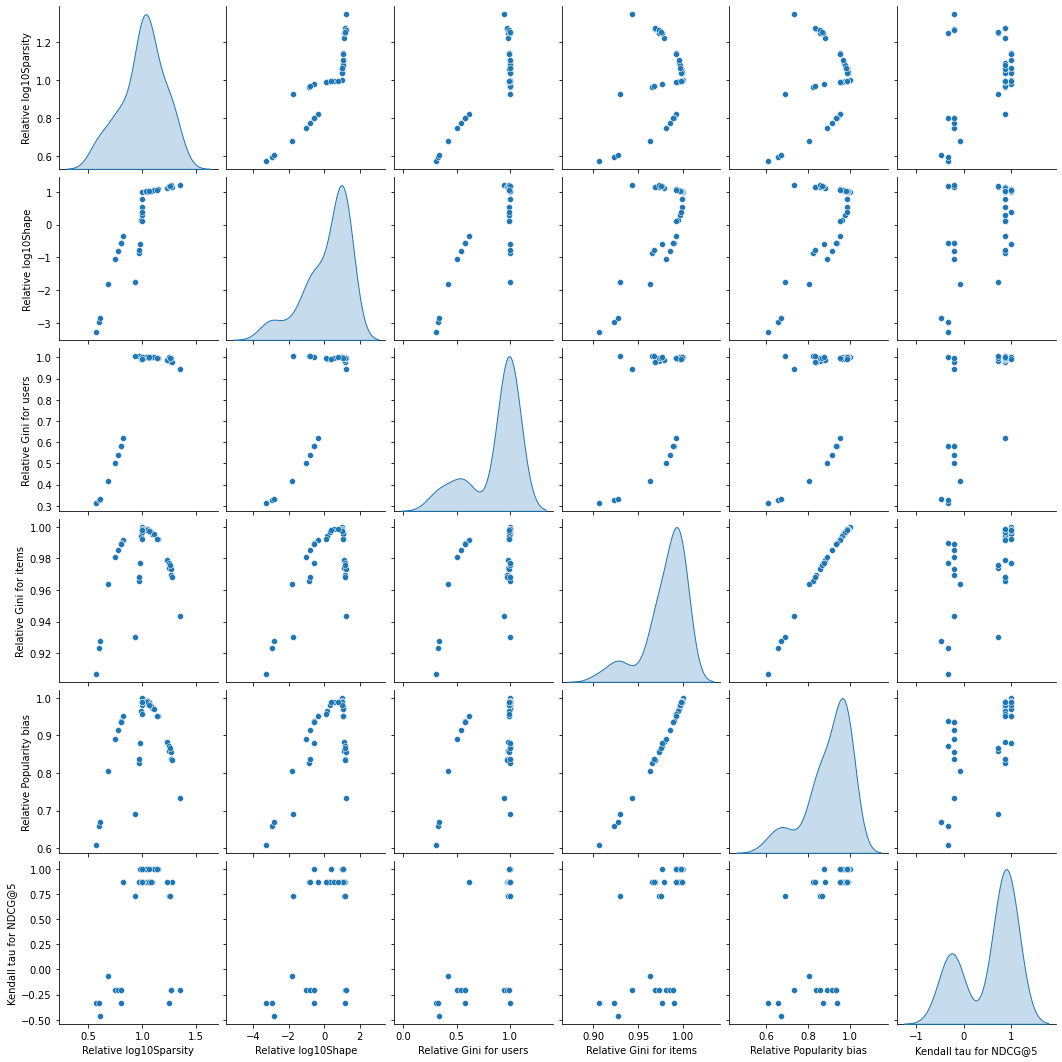

In [14]:
sns.pairplot(df[[
    'Relative log10Sparsity',
    'Relative log10Shape',
    'Relative Gini for users',
    'Relative Gini for items',
    'Relative Popularity bias',
    'Kendall tau for NDCG@5'
    ]], diag_kind='kde')
plt.savefig('/drive/My Drive/Colab Notebooks/dataset.png')

Drop Variables

In [15]:
df.drop([
    'Relative Gini for items'
         ], axis=1, inplace=True)

Correlation Matrix

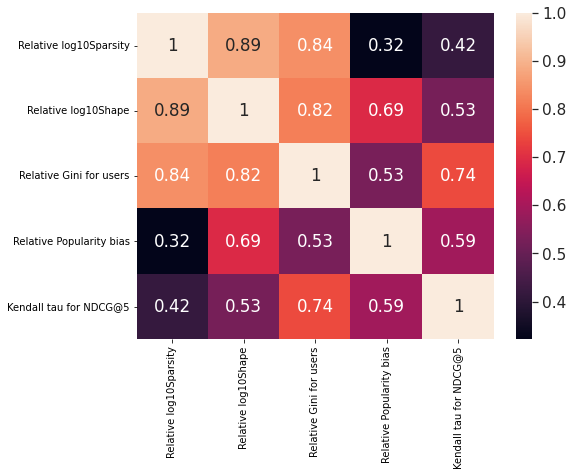

In [16]:
corrMatrix = df.corr(method='pearson')
fig, ax = plt.subplots()
fig.set_size_inches(8, 6)
sns.set(font_scale=1.4)
sns.heatmap(corrMatrix, annot=True)

Add prior knowledge to Graph Causal Discovery

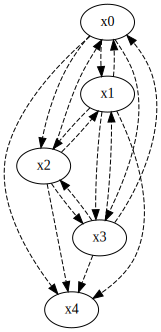

In [19]:
prior_knowledge = make_prior_knowledge(
    n_variables=5,
    sink_variables=[4],
    #n_variables=6,
    #sink_variables=[5],
)
make_prior_knowledge_graph(prior_knowledge)

Discover Causality Graph using LiNGAM

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:138: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:138: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing

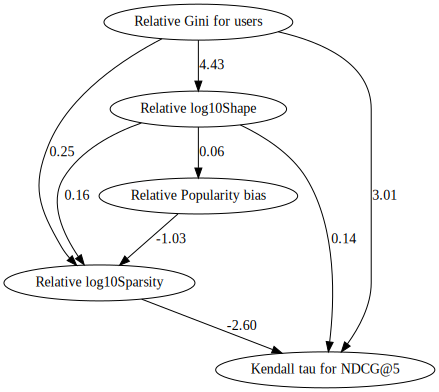

In [20]:
graphs = {}
labels = [f'{col}' for i, col in enumerate(df.columns)]
obj = lingam.DirectLiNGAM(prior_knowledge=prior_knowledge)
obj.fit(df)
adj_matrix = obj.adjacency_matrix_
graph_dot = make_dot(adj_matrix, labels=labels)
# Save png
graph_dot.format = 'png'
graph_dot.render('/drive/My Drive/Colab Notebooks/causal_graph')
graph_dot

Adjaciency Matrix

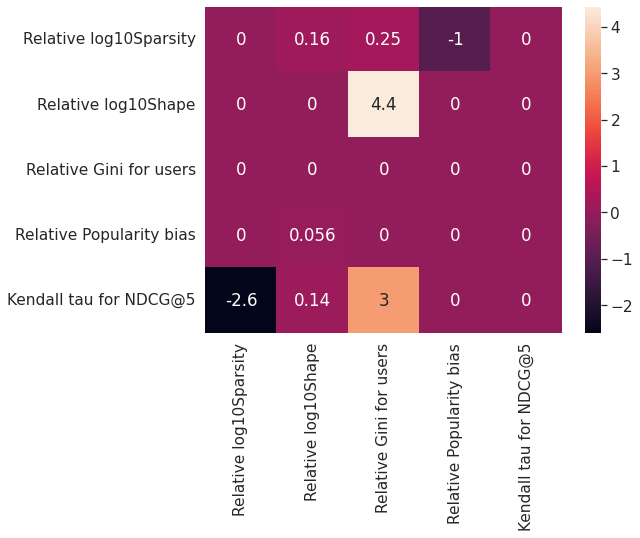

In [22]:
df_adj_matrix = pd.DataFrame(adj_matrix, index=df.columns, columns=df.columns)
fig, ax = plt.subplots()
fig.set_size_inches(8, 6)
sns.set(font_scale=1.4)
sns.heatmap(df_adj_matrix, annot=True)

Obtain valid dot format

In [31]:
graph_dot_str = str_to_dot(graph_dot.source)
print(graph_dot_str)

digraph {"Relative log10Shape" -> "Relative log10Sparsity" [label=0.16];"Relative Gini for users" -> "Relative log10Sparsity" [label=0.25];"Relative Popularity bias" -> "Relative log10Sparsity" [label=-1.03];"Relative Gini for users" -> "Relative log10Shape" [label=4.43];"Relative log10Shape" -> "Relative Popularity bias" [label=0.06];"Relative log10Sparsity" -> "Kendall tau for NDCG@5" [label=-2.60];"Relative log10Shape" -> "Kendall tau for NDCG@5" [label=0.14];"Relative Gini for users" -> "Kendall tau for NDCG@5" [label=3.01]}


Define treatment and output

In [23]:
treatment='Relative Popularity bias'
outcome='Kendall tau for NDCG@5'

Define Causal Inference Model

In [32]:
model=CausalModel(
        data = df,
        treatment=treatment,
        outcome=outcome,
        graph=graph_dot_str)
# Identification
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True,optimize_backdoor=False)
print(identified_estimand)
# Estimation
estimate = model.estimate_effect(identified_estimand,method_name="backdoor.linear_regression")

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
             d                                                                
───────────────────────────(Expectation(Kendall tau for NDCG@5|Relative log10S
d[Relative Popularity bias]                                                   

      
hape))
      
Estimand assumption 1, Unconfoundedness: If U→{Relative Popularity bias} and U→Kendall tau for NDCG@5 then P(Kendall tau for NDCG@5|Relative Popularity bias,Relative log10Shape,U) = P(Kendall tau for NDCG@5|Relative Popularity bias,Relative log10Shape)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!

linear_regression
{'control_value': 0, 'treatment_value': 1, 'test_significance': None, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}


Refutation Checks

In [33]:
# Adding a random common cause variable
res_random=model.refute_estimate(identified_estimand, estimate, method_name="random_common_cause", random_seed = 1)
print(res_random)
# Removing a random subset of the data
res_subset=model.refute_estimate(identified_estimand, estimate,
        method_name="data_subset_refuter", subset_fraction=0.9, random_seed = 1)
print(res_subset)
# Replacing treatment with a random (placebo) variable
res_placebo=model.refute_estimate(identified_estimand, estimate,
        method_name="placebo_treatment_refuter", placebo_type="permute", random_seed = 1)
print(res_placebo)

{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate

Textual Interpreter

In [34]:
interpretation = estimate.interpret(method_name="textual_effect_interpreter")

Increasing the treatment variable(s) [Relative Popularity bias] from 0 to 1 causes an increase of 2.304753583158551 in the expected value of the outcome [Kendall tau for NDCG@5], over the data distribution/population represented by the dataset.


Causal Plot 

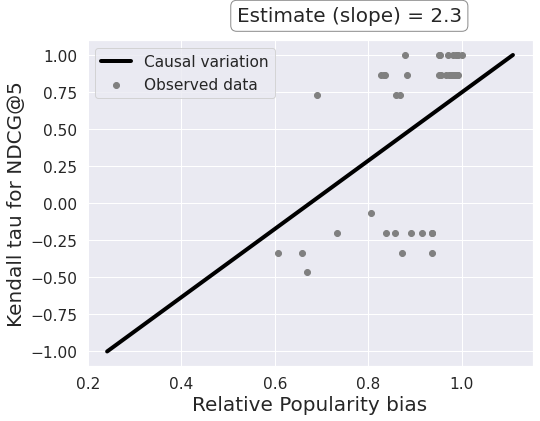

In [38]:
my_plot_causal_effect(estimate, treatment, outcome, df[treatment], df[outcome]) 